In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
from numbalsoda import lsoda, lsoda_sig
from numba import cfunc, njit
import matplotlib.pyplot as plt
import pandas as pd
from lmfit.model import Model, save_modelresult, load_modelresult
import math

# =============================================================================
# Define functions
# =============================================================================

def calc_kadd_from_eyring(temp, m, b, S):
    """
    Calculate the association rate constant (k_add) from Eyring equation parameters.

    Parameters
    ----------
    temp : float
        Temperature in Kelvin.
    m : float
        Slope of the Eyring plot.
    b : float
        Intercept of the Eyring plot.
    S : float
        Concentration of probe in M.

    Returns
    -------
    float
        Association rate constant (k_add) in units of M^-1 s^-1.
    """

    eyring_y = m * (1 / temp) + b
    return (np.exp(eyring_y) * temp) / S

def ode_solution(y0, rates, x):
    """
    Solve a system of ordinary differential equations (ODEs) for chemical probing.

    Parameters
    ----------
    y0 : numpy array
        Initial values for the ODEs - U, R, S, M, Z.
    rates : numpy array
        Rate constants for the ODEs - k_o, k_c, k_add, k_deg.
    x : numpy array
        Time points to evaluate the ODEs.

    Returns
    -------
    x : ndarray
        Array of time points.
    y : ndarray
        Array of the fraction of M over (U + R + M) at each time point.
    """

    @cfunc(lsoda_sig)
    def chem_probing_fastODE(t, y, du, p):
        du[0] = -p[0]*y[0] + p[1]*y[1]
        du[1] = p[0]*y[0] - p[1]*y[1] - p[2]*y[1]*y[2]
        du[2] = -p[2]*y[1]*y[2] - p[3]*y[2]
        du[3] = p[2]*y[1]*y[2]
        du[4] = p[3]*y[2]

    # address to ODE function
    funcptr = chem_probing_fastODE.address
    t_eval = x

    # integrate with lsoda method
    sol, success = lsoda(funcptr, y0, t_eval, data = rates)

    # calculate fraction of M over (U + R + M)
    y = sol[:, 3] / (sol[:, 0] + sol[:, 1] + sol[:, 3])

    return y

def pe_model(x, K, k_add, k_deg, S):
    """ Pre-equilibrium assumption model """
    kappa = ((K / (K + 1)) * k_add * S) / k_deg
    return 1 - np.exp(-kappa * (1 - np.exp(-k_deg * x)))

def ss_model(x, k_o, k_c, k_add, k_deg, S):
    """ Steady-state approximation model """
    num = k_o * k_add * S
    denom = k_o + k_c * k_add * S
    k_obs = num / denom
    kappa = k_obs / k_deg
    return 1 - np.exp(-kappa * (1 - np.exp(-k_deg * x)))

def solve_fmod(k_c, lnkhydr_model, k_add_mb, temp = 45, rna_conc = 1e-6, K = 0.5):
    """ Solve the ODEs and calculate the pre-equilibrium assumption and steady-state approximation models """
    
    k_o = K * k_c

    S = 0.01584
    temp += 273.15 # convert to Kelvin
    k_add_m, k_add_b = k_add_mb
    k_add = calc_kadd_from_eyring(temp, k_add_m, k_add_b, S)
    k_deg = np.exp(lnkhydr_model.eval(x=1 / temp)) * temp
    k_add = k_deg / S

    # Calculate initial conc U, R based on K
    U0 = rna_conc / (1 + K)
    R0 = K * U0
    
    print(f' - U0 = {U0}')
    print(f' - R0 = {R0}')

    # Initial concentrations of U, R, S, M, Z
    y0 = np.array([U0, R0, S, 0.0, 0.0])

    # Rate constants
    rates = np.array([k_o, k_c, k_add, k_deg])
    
    # Print all rate constants
    print(f' - k_o = {k_o}')
    print(f' - k_c = {k_c}')
    print(f' - k_add = {k_add}')
    print(f' - k_deg = {k_deg}')

    # Solve for fmod (% modification)
    x = np.linspace(0, 2000, 50)
    y_ode = ode_solution(y0, rates, x)
    y_pe = pe_model(x, K, k_add, k_deg, S)
    y_ss = ss_model(x, k_o, k_c, k_add, k_deg, S)

    # Calculate residuals
    res_pe = y_pe - y_ode
    res_ss = y_ss - y_ode

    return {'x': x, 'y_ode': y_ode, 'y_pe': y_pe, 'res_pe': res_pe, 'y_ss': y_ss, 'res_ss': res_ss}

def plot_solutions(x, y_ode, y_pe, res_pe, y_ss, res_ss, t, ax):

    ax.plot(x, y_ode, label='ODE solution', ls='-', lw = 2, color='#fac748')
    ax.plot(x, y_pe, label='Pre-equilibrium assumption', marker = 'o', markersize = 1, ls='', color='#1d2f6f')

    exp = -int(math.log10(t))
    ax.text(0.95, 0.15, rf'$10^{{{exp}}}$ s', transform=ax.transAxes, ha='right', va='top', fontsize=10)

    #ax.set_ylabel(r'$f_{mod}$')
    #ax.set_xlabel('Time (s)')

    return ax


def plot_correlation(x, y_ode, y_pe, res_pe, y_ss, res_ss, t, ax, concs = False):

    if concs:
        ax.plot(y_ode, y_pe, label=f'{t * 1000} mM', alpha = 0.5)

    else:
        ax.plot(y_ode, y_pe, label=f'{int(1/t)} s', alpha = 0.5)

    return ax

 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500000000000.0
 - k_c = 1000000000000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500000000.0
 - k_c = 1000000000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500000.0
 - k_c = 1000000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 500.0
 - k_c = 1000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 0.5
 - k_c = 1.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 0.0005
 - k_c = 0.001
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 6.666666666666666e-07
 - R0 = 3.33333

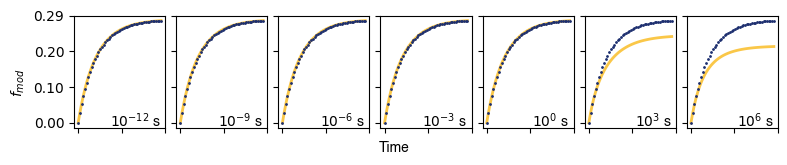

In [2]:

# =============================================================================
# Solve ODEs and plot
# =============================================================================

khydr_modelpath = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/01_ODE_v_analytical/02_eyring_hydrolysis_rate/k_hydr.sav'

lnkhydr_model = load_modelresult(khydr_modelpath)
k_add_mb = (-419.754617, -10.682813)

timescales = [1e12, 1e9, 1e6, 1e3, 1e0, 1e-3, 1e-6]
n = len(timescales)
# plot residue in a subplot above
fig, axs = plt.subplots(1, n, sharey = True, figsize=(8, 1.5))
plt.rcParams['font.family'] = 'Helvetica'

for i, t in enumerate(timescales):
    plot_solutions(**solve_fmod(t, lnkhydr_model, k_add_mb, 45), t = t, ax = axs[i])
    axs[i].set_xticks([0, axs[i].get_xlim()[1]/2, axs[i].get_xlim()[1]])
    axs[i].set_xticklabels([])

    # Set y-tick marks
    yticks = np.linspace(0, axs[i].get_ylim()[1], 4)
    axs[i].set_yticks(np.linspace(0, axs[i].get_ylim()[1], 4))
    axs[i].set_yticklabels([f"{ytick:.2f}" for ytick in yticks])

fig.text(0.02, 0.5, r'$f_{mod}$', va='center', rotation='vertical')
fig.text(0.5, 0.04, 'Time', ha='center')
plt.subplots_adjust(wspace = 0.12, left = 0.1, right = 0.98, bottom = 0.2, top = 0.95)

plt.show()

 - U0 = 6.666666666666666e-07
 - R0 = 3.333333333333333e-07
 - k_o = 100.0
 - k_c = 200.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477


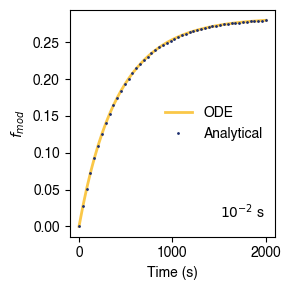

In [3]:

# =============================================================================
# Solve ODEs and plot
# =============================================================================

khydr_modelpath = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/01_ODE_v_analytical/02_eyring_hydrolysis_rate/k_hydr.sav'

lnkhydr_model = load_modelresult(khydr_modelpath)
k_add_mb = (-419.754617, -10.682813)

fig, ax = plt.subplots(figsize=(3, 3))
plt.rcParams['font.family'] = 'Helvetica'

t = 2e2
plot_solutions(**solve_fmod(t, lnkhydr_model, k_add_mb, 45), t = t, ax = ax)
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$f_{mod}$')
# change legend entries to 'ODE' and 'Analytical'
ax.legend(['ODE', 'Analytical'], frameon=False)

plt.tight_layout()
plt.savefig('fmod_vs_time.pdf')
plt.show()

 - U0 = 9.090909090909089e-07
 - R0 = 9.09090909090909e-08
 - k_o = 2000.0
 - k_c = 20000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477


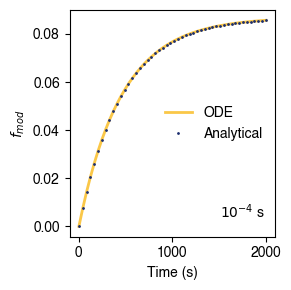

In [15]:

# =============================================================================
# Solve ODEs and plot
# =============================================================================

khydr_modelpath = '/Users/edricchoi/LucksLab Dropbox/LucksLab/Lucks_Lab_Papers/In_Progress/88_EKC_Probing_model/Manuscript/Data_elements/01_ODE_v_analytical/02_eyring_hydrolysis_rate/k_hydr.sav'

lnkhydr_model = load_modelresult(khydr_modelpath)
k_add_mb = (-419.754617, -10.682813)

fig, ax = plt.subplots(figsize=(3, 3))
plt.rcParams['font.family'] = 'Helvetica'

t = 2e4
plot_solutions(**solve_fmod(t, lnkhydr_model, k_add_mb, 45, K = 0.1), t = t, ax = ax)
ax.set_xlabel('Time (s)')
ax.set_ylabel(r'$f_{mod}$')
# change legend entries to 'ODE' and 'Analytical'
ax.legend(['ODE', 'Analytical'], frameon=False)

plt.tight_layout()
#plt.savefig('fmod_vs_time.pdf')
plt.show()

 - U0 = 1.3333333333333332e-06
 - R0 = 6.666666666666666e-07
 - k_o = 0.5
 - k_c = 1.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 1.3333333333333332e-06
 - R0 = 6.666666666666666e-07
 - k_o = 0.005
 - k_c = 0.01
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 1.3333333333333332e-06
 - R0 = 6.666666666666666e-07
 - k_o = 0.0005
 - k_c = 0.001
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 1.3333333333333332e-06
 - R0 = 6.666666666666666e-07
 - k_o = 5e-07
 - k_c = 1e-06
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477


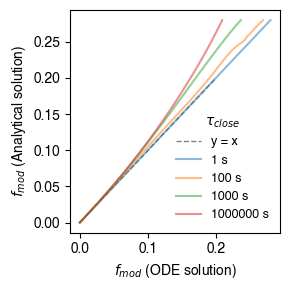

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.rcParams['font.family'] = 'Helvetica'

# draw a diagonal line
x = np.linspace(0, 0.2, 100)
y = x
ax.plot(x, y, ls='--', color='grey', lw = 1, label = 'y = x')


timescales = [1e0, 1e-2, 1e-3, 1e-6]

for i, t in enumerate(timescales):
    plot_correlation(**solve_fmod(t, lnkhydr_model, k_add_mb, 45, 2e-6), t = t, ax = ax)
    
ax.set_xlabel(r'$f_{mod}$ (ODE solution)')
ax.set_ylabel(r'$f_{mod}$ (Analytical solution)')

# set x and y lim to 0.1
#ax.set_xlim(0, 0.05)
# ax.set_ylim(0, 0.05)
ax.legend(title = r'$\tau_{close}$', frameon = False, fontsize = 9)
plt.tight_layout()
plt.savefig('exports/ode_v_analytical_fmod_correlation.pdf')
plt.show()

 - U0 = 0.06666666666666667
 - R0 = 0.03333333333333333
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 0.03333333333333333
 - R0 = 0.016666666666666666
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 0.01
 - R0 = 0.005
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477
 - U0 = 0.0006666666666666666
 - R0 = 0.0003333333333333333
 - k_o = 5000.0
 - k_c = 10000.0
 - k_add = 0.1328725288456596
 - k_deg = 0.0021047008569152477


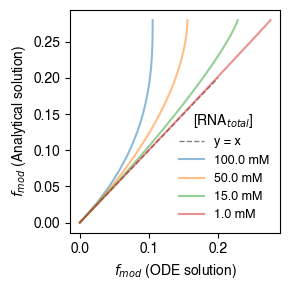

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
plt.rcParams['font.family'] = 'Helvetica'

# draw a diagonal line
x = np.linspace(0, 0.2, 100)
y = x
ax.plot(x, y, ls='--', color='grey', lw = 1, label = 'y = x')

concs = [0.1, 0.05, 0.015, 0.001]

for i, c in enumerate(concs):
    plot_correlation(**solve_fmod(1e4, lnkhydr_model, k_add_mb, 45, c), t = c, ax = ax, concs = True)
    
ax.set_xlabel(r'$f_{mod}$ (ODE solution)')
ax.set_ylabel(r'$f_{mod}$ (Analytical solution)')

# set x and y lim to 0.1
#ax.set_xlim(0, 0.05)
#ax.set_ylim(0, 0.05)
ax.legend(title = r'[RNA$_{total}$]', frameon = False, fontsize = 9)
plt.tight_layout()
plt.savefig('exports/ode_v_analytical_fmod_correlation_conctest.pdf')
plt.show()